In [1]:
import numpy as np
import matplotlib
# %matplotlib notebook
import matplotlib.pyplot as plt
import os
import sys
import pickle
from struct import *
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

## Find highest luminance
The purpose of this script is to find the frame in which highest luminance occurs for all HMD:task:subID combinations. The shared event in the full and clipped videos will allow us to then calculate the video offsets.

Outputs mean_luminance.csv.

In [2]:
def find_between(s, first, last):
    try:
        start = s.index(first)+len(first)
        end = s.index(last, start)
        return s[start:end]
    except:
        return ""

In [3]:
# Create a reference of paths to luminance files
lum_data = pd.DataFrame({'HMD':[], 'subID':[], 'task':[], 'type':[], 'path':[]})
paths_to_load = {'PI':'/data/AMPs/first-round/avg-lum-per-frame/', 
                 'varjo':'/data/AMPs/second-round/avg-lum-per-frame/'}

# Load varjo
for HMD, path in paths_to_load.items():
    for fname in os.listdir(path):
        temp = pd.read_csv(path+fname)
        subID = find_between(fname, '', '_')
        task = find_between(fname, '_', '_')
        if "merged" in fname:
            t = 'merged'
        else:
            t = 'full'
        lum_data = pd.concat([lum_data, pd.DataFrame({'HMD':[HMD], 
                                                        'subID':[subID], 
                                                        'task':[task],
                                                        'type':[t], 
                                                        'path':[path+fname]})], ignore_index=True)

In [4]:
# For each HMD:task:subID pair, find the frame of highest luminance
# store the timestamp of highest percent change
min_max_lum = pd.DataFrame({'HMD':[], 'task':[], 'subID':[], 'type':[], 'lum_path':[], 'dur(s)':[], 
                            'max_lum_roc':[], 'max_lum_frame':[], 'max_lum_time(s)':[],
                            'min_lum_roc':[], 'min_lum_frame':[], 'min_lum_time(s)':[]})
fps = {'PI':{'full':30.000029, 'merged':29.970030}, 'varjo':{'full':30.000029, 'merged':29.970030}}
method = 'mean' # <-- CHANGE HERE: can choose between ['mean', 'median'] luminance

# gather luminance data
for HMD in lum_data.HMD.unique():
    for task in lum_data[lum_data.HMD==HMD].task.unique():
        _ = lum_data[lum_data.HMD==HMD][lum_data.task==task]
        for subID in _.subID.unique():
            temp = _[_.subID==subID]
            # only proceed if there exists luminance data for both full and merged videos
            try:
                path_full = temp[temp.type=='full'].path.values[0]
                path_merged = temp[temp.type=='merged'].path.values[0]
                l_full = pd.read_csv(path_full)
                l_merged = pd.read_csv(path_merged)
                dur_full = l_full.frame.max()/fps[HMD]['full']
                dur_merged = l_merged.frame.max()/fps[HMD]['merged']
            except:
                continue
            l_df = {'full':l_full, 'merged':l_merged}
            paths = {'full':path_full, 'merged':path_merged}
            dur = {'full':dur_full, 'merged':dur_merged}
            
            # calculate max and min rate of change for each luminance df
            for t, l in l_df.items():
                l['ROC'] = l[method].pct_change()
                
                # only look in the first half of the videos
                max_lum_roc, min_lum_roc = l.loc[:len(l)//2,'ROC'].max(), l.loc[:len(l)//2,'ROC'].min()
                frame_max_lum, frame_min_lum = l.loc[:len(l)//2,'ROC'].idxmax(), l.loc[:len(l)//2,'ROC'].idxmin()
                
                time_max_lum = l.loc[frame_max_lum,'frame']/fps[HMD][t]
                time_min_lum = l.loc[frame_min_lum,'frame']/fps[HMD][t]
                
                min_max_lum = pd.concat([min_max_lum, pd.DataFrame({'HMD':[HMD],
                                                            'task':[task], 
                                                            'subID':[subID],
                                                            'type':[t],
                                                            'lum_path':[paths[t]],
                                                            'dur(s)':[dur[t]],
                                                            'max_lum_roc':[max_lum_roc],
                                                            'max_lum_frame':[frame_max_lum],
                                                            'max_lum_time(s)':[time_max_lum],
                                                            'min_lum_roc':[min_lum_roc],
                                                            'min_lum_frame':[frame_min_lum],
                                                            'min_lum_time(s)':[time_min_lum]})], ignore_index=True)

In [5]:
min_max_lum.head()

,HMD,task,subID,type,lum_path,dur(s),max_lum_roc,max_lum_frame,max_lum_time(s),min_lum_roc,min_lum_frame,min_lum_time(s)
0,PI,sandwich,P23,full,/data/AMPs/first-round/avg-lum-per-frame/P23_s...,1152.432219,0.471009,583.0,19.433315,-0.251788,1042.0,34.733300
1,PI,sandwich,P23,merged,/data/AMPs/first-round/avg-lum-per-frame/P23_s...,1145.010532,0.230259,197.0,6.573233,-0.201950,830.0,27.694333
2,PI,sandwich,P13,full,/data/AMPs/first-round/avg-lum-per-frame/P13_s...,548.566136,0.481926,789.0,26.299975,-0.335966,790.0,26.333308
3,PI,sandwich,P13,merged,/data/AMPs/first-round/avg-lum-per-frame/P13_s...,523.923399,0.308122,62.0,2.068733,-0.320189,95.0,3.169833
4,PI,sandwich,P6,full,/data/AMPs/first-round/avg-lum-per-frame/P6_sa...,712.832644,0.900414,1807.0,60.233275,-0.801127,1808.0,60.266608


In [6]:
# save the luminance dataframe
out_path = '/data/Isabella/thesis_spring2022/offsets/'
min_max_lum.to_csv(f'{out_path}{method}_luminance.csv')
out_path = '/home/s202576/thesis_spring2022/NN/data_prep/'
min_max_lum.to_csv(f'{out_path}{method}_luminance.csv')

## Plot results

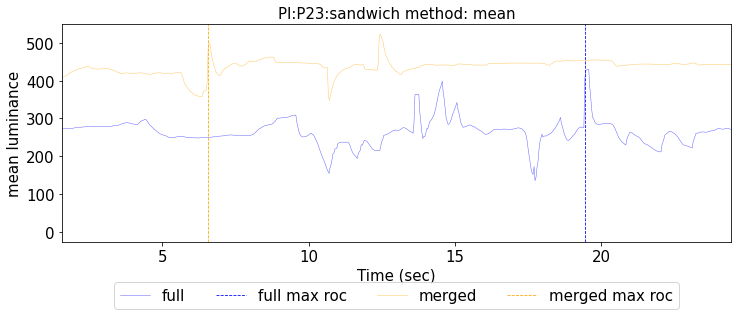

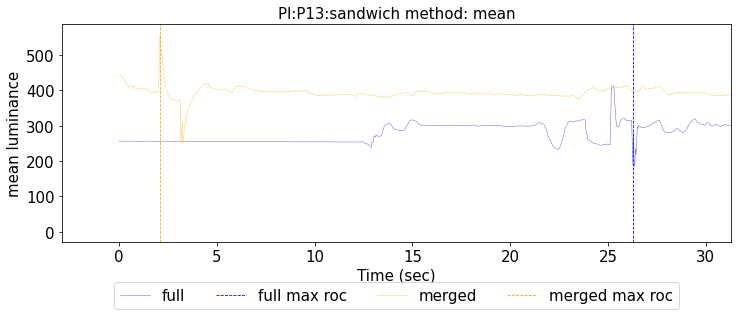

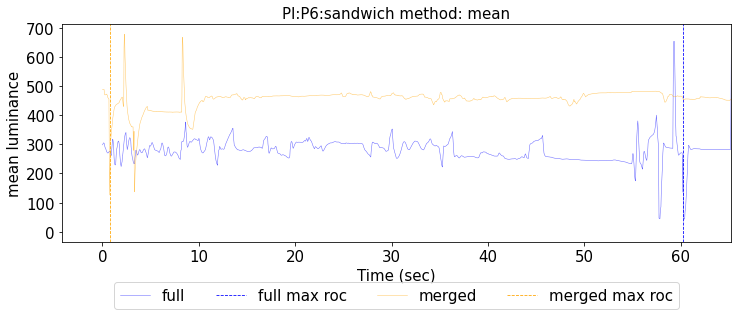

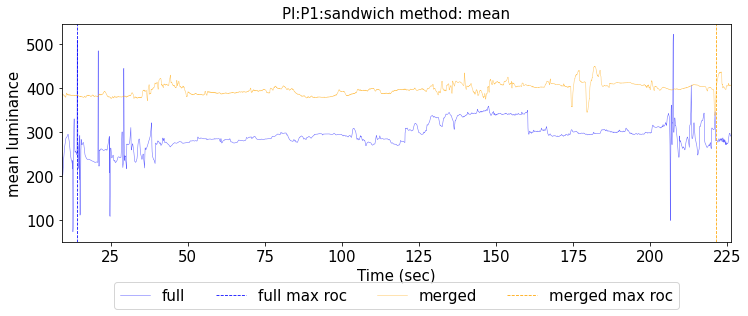

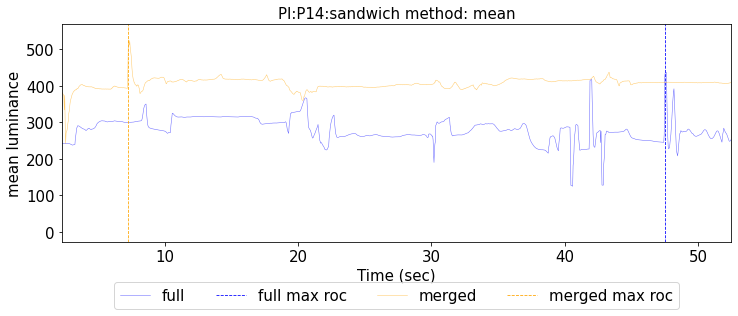

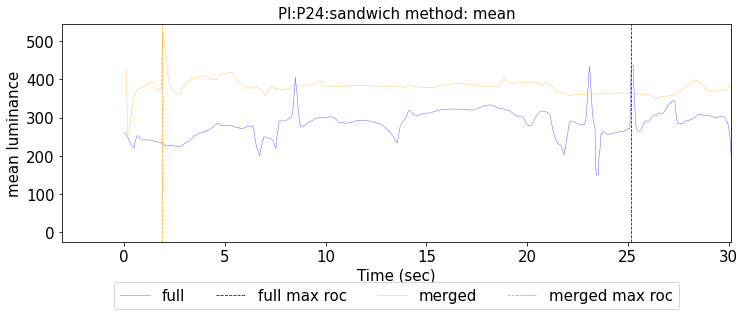

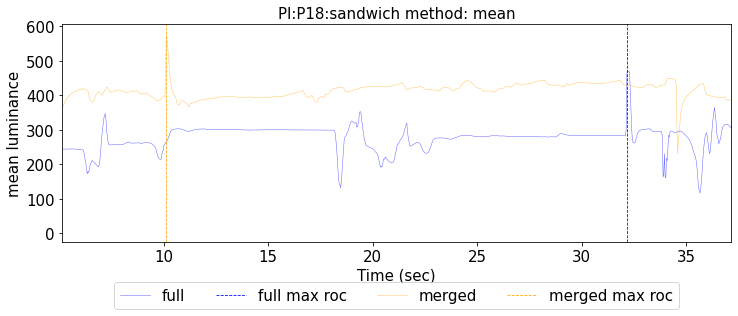

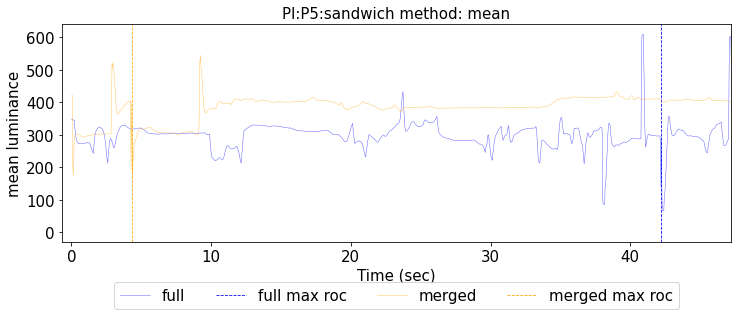

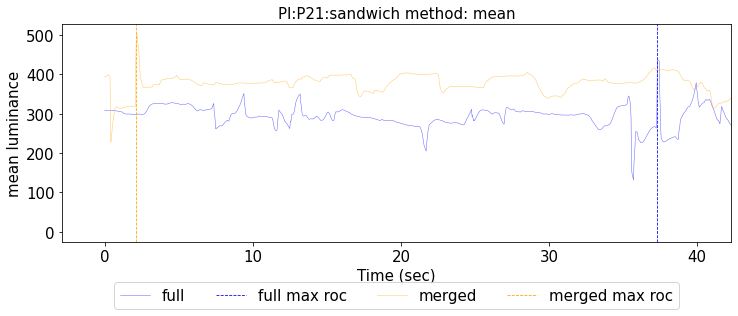

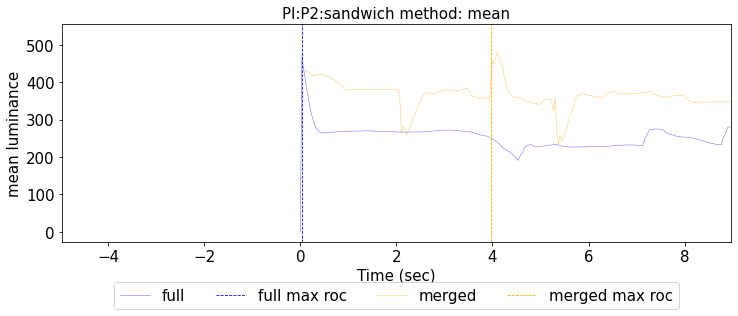

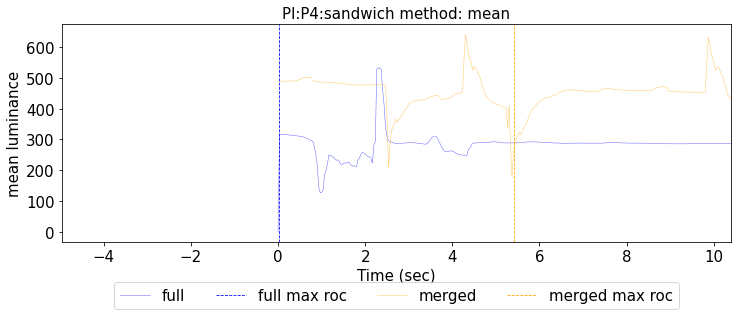

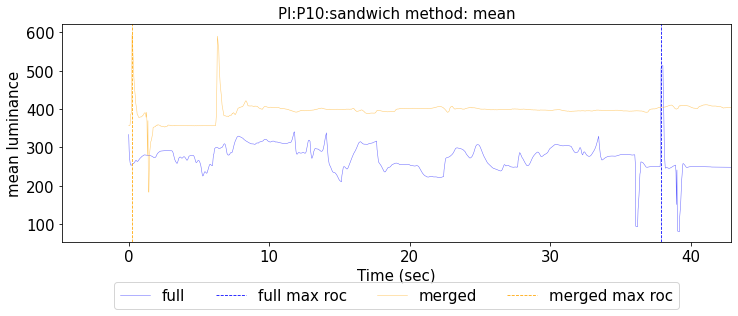

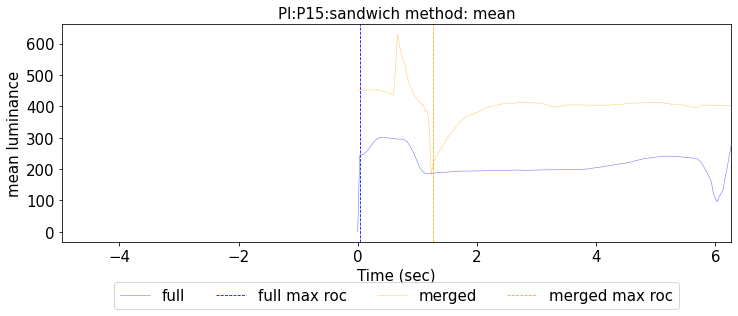

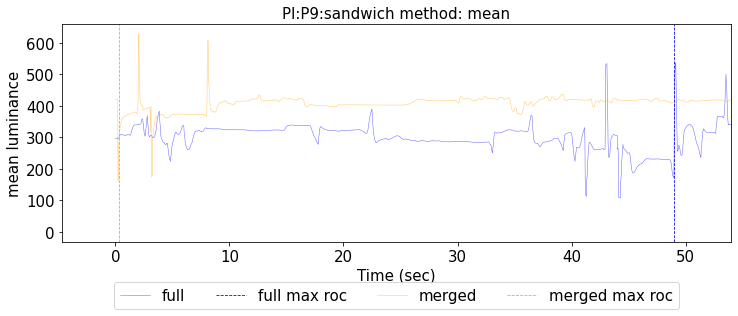

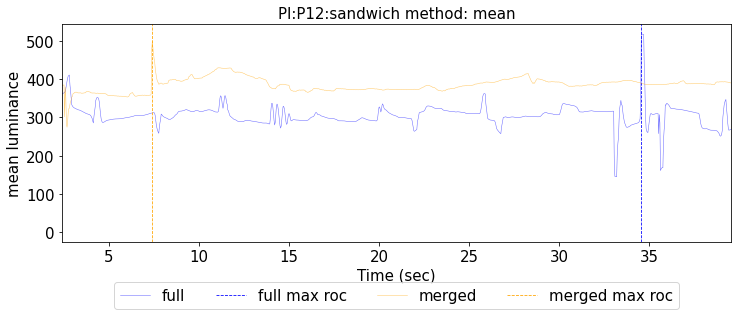

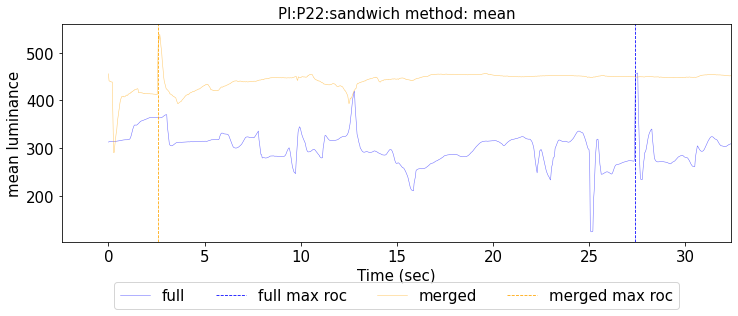

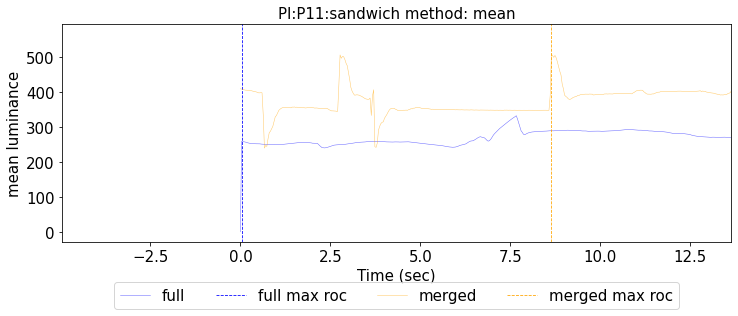

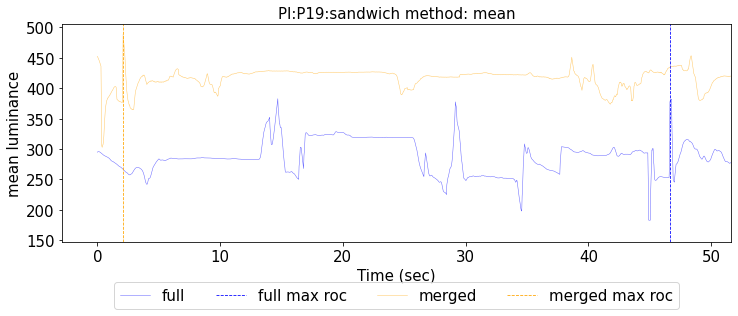

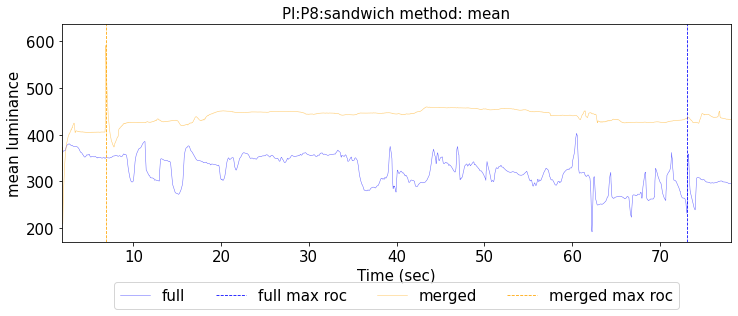

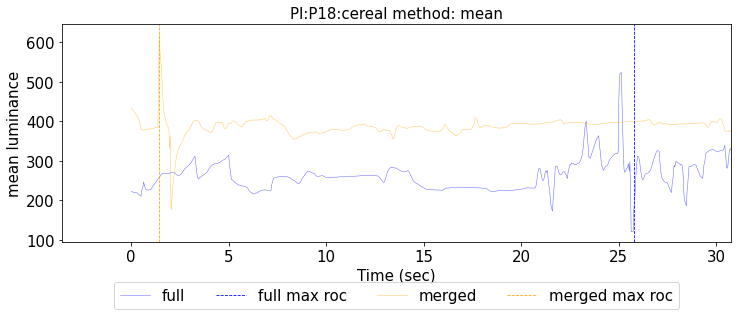

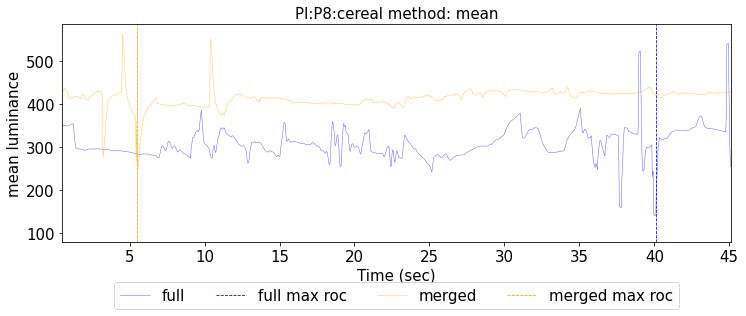

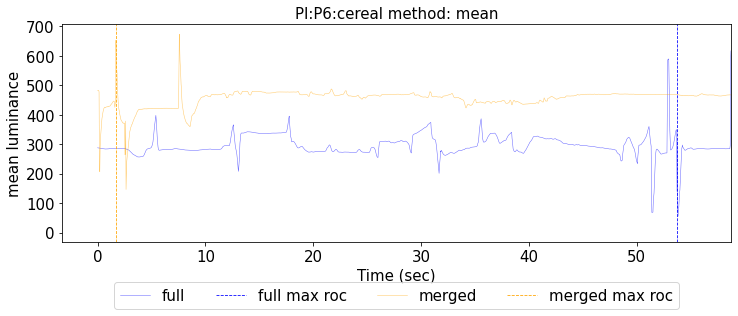

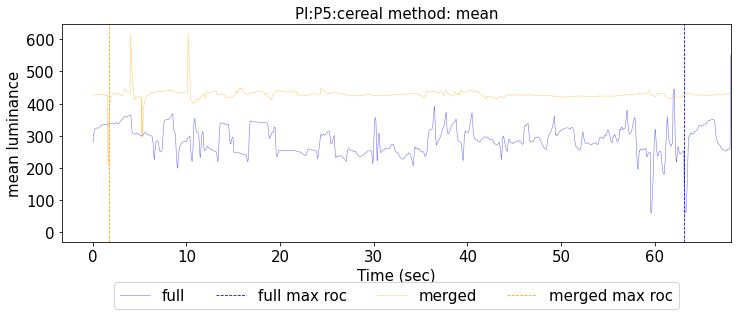

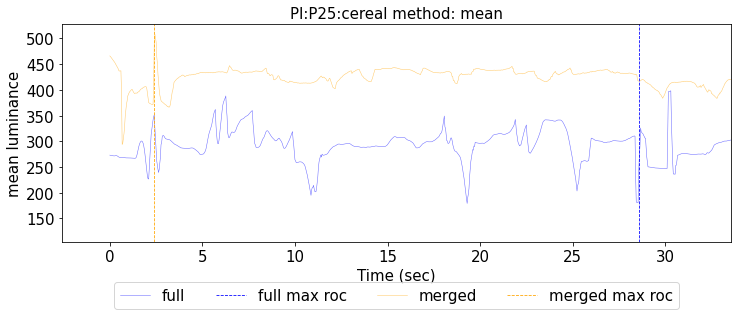

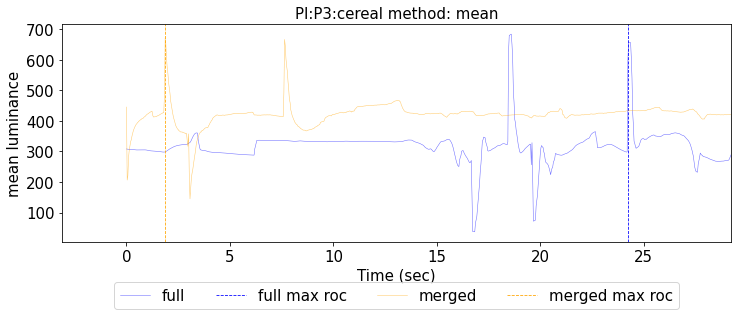

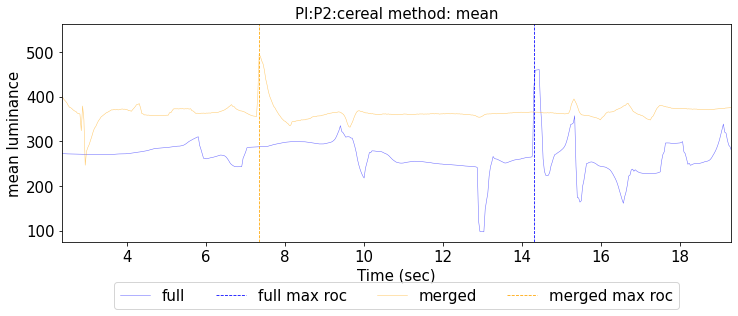

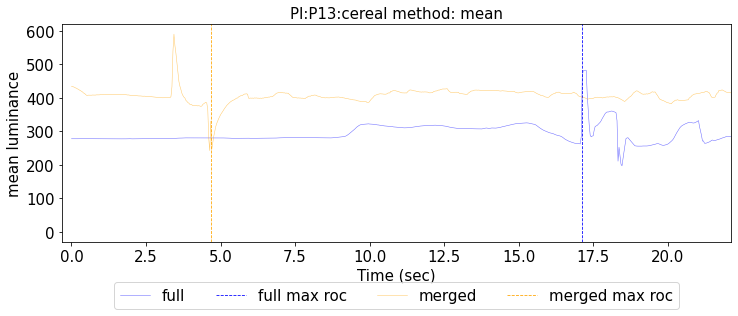

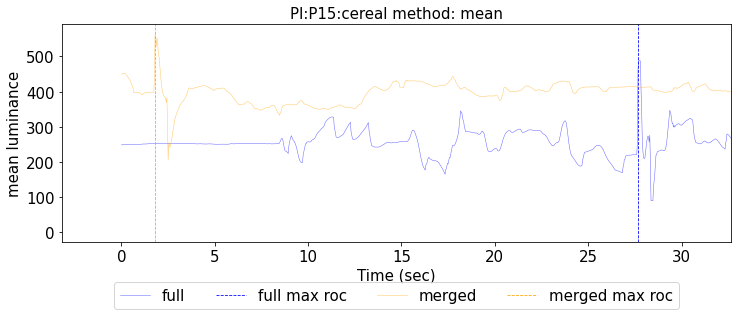

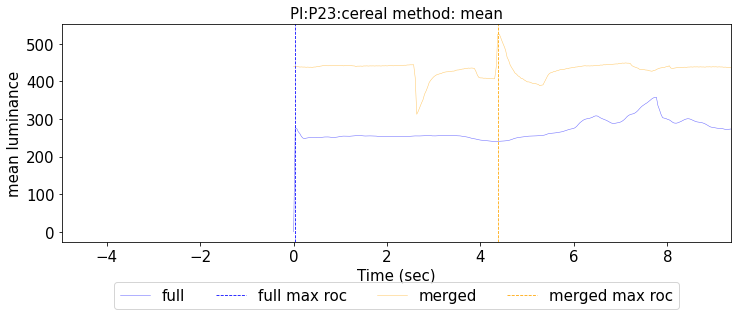

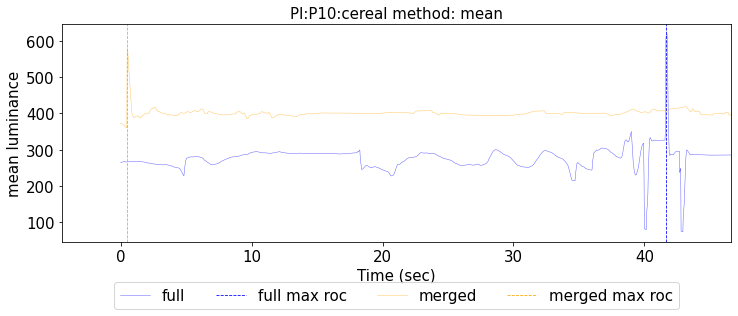

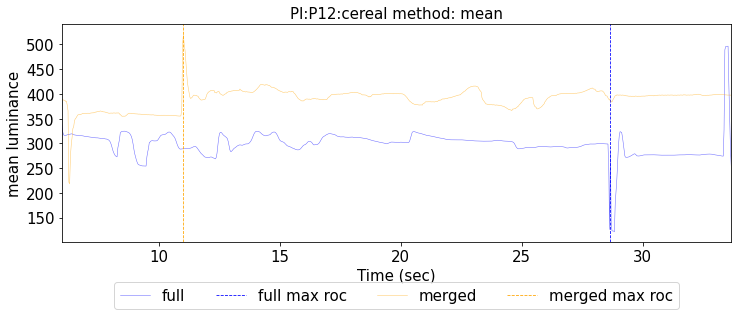

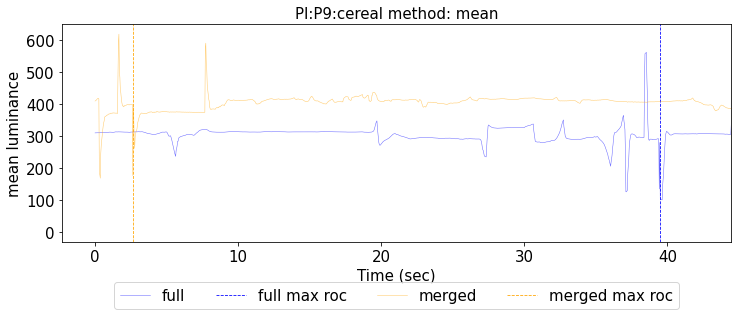

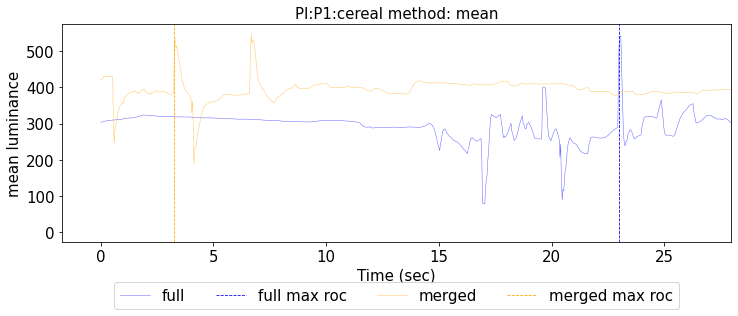

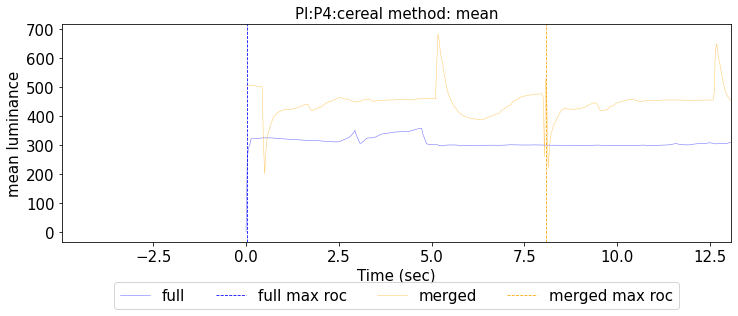

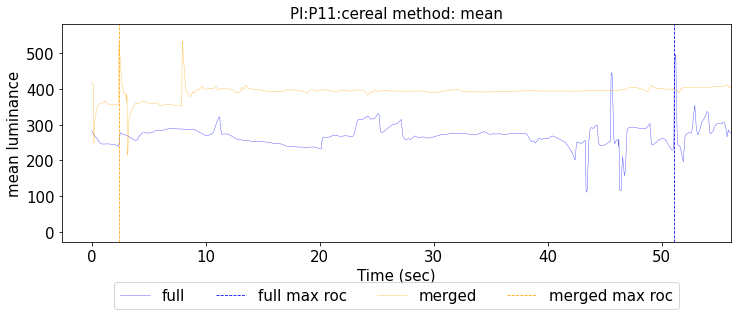

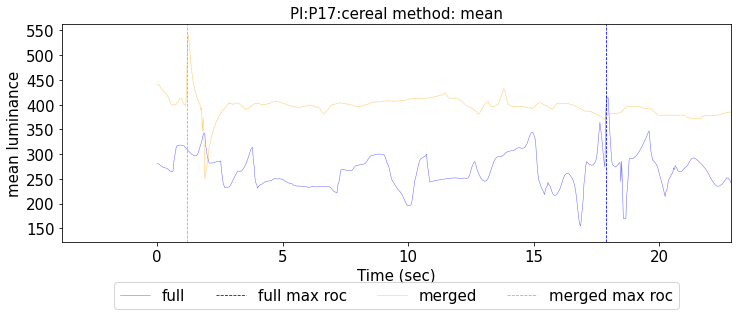

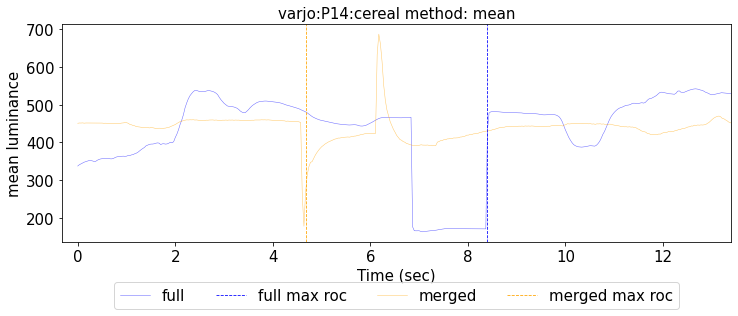

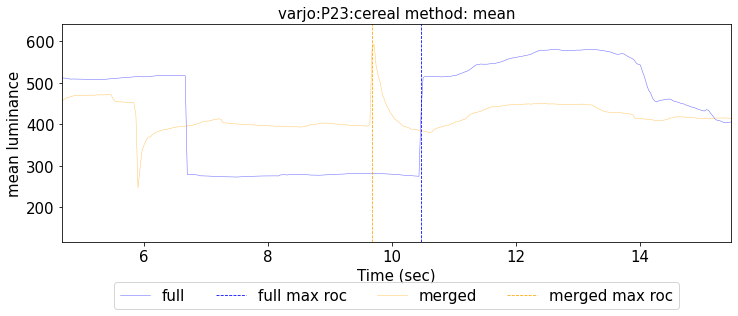

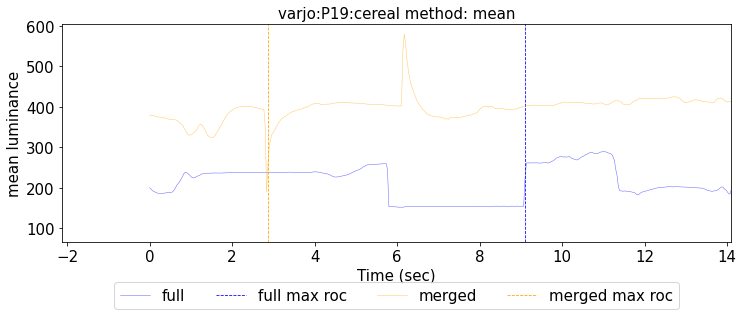

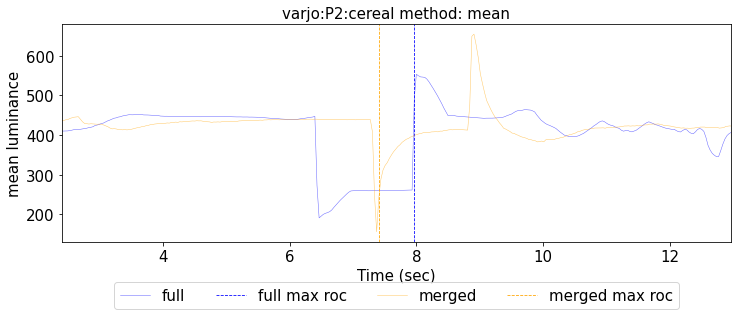

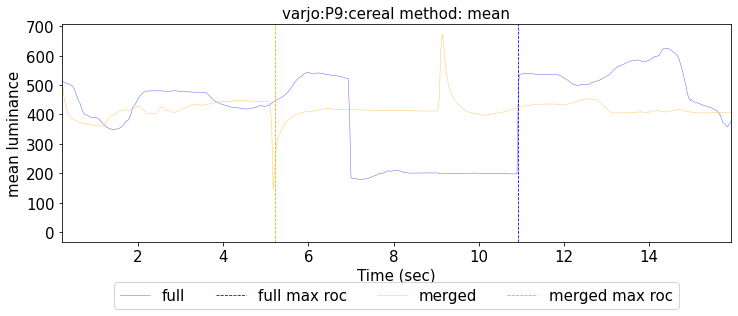

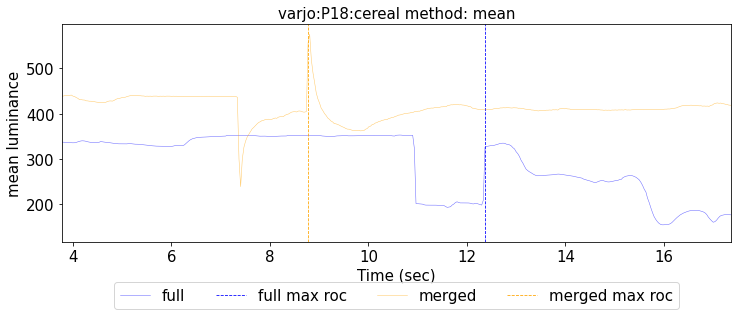

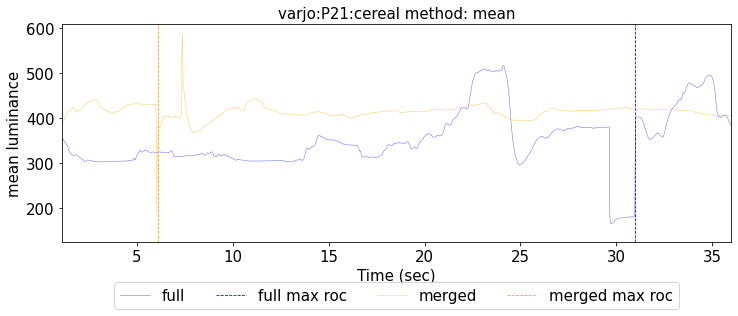

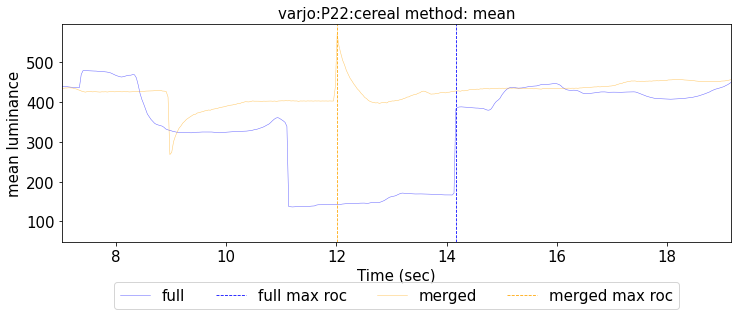

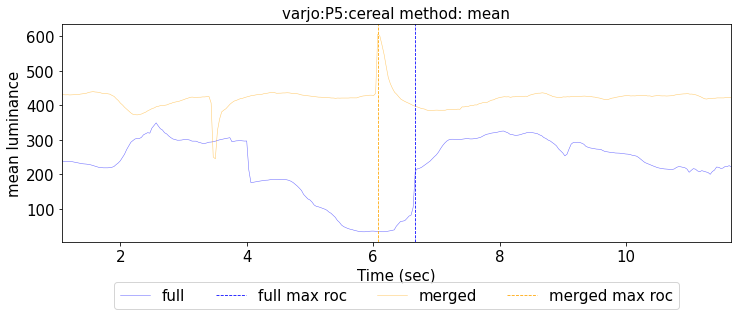

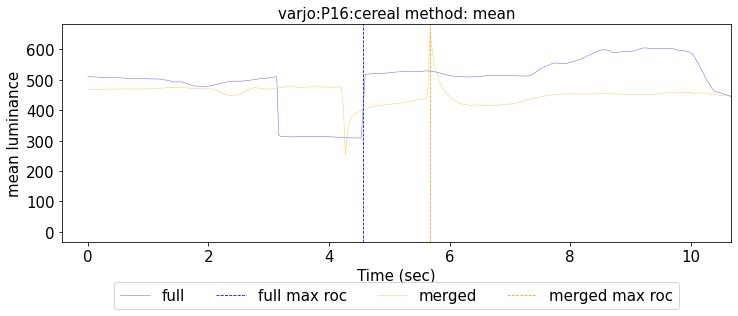

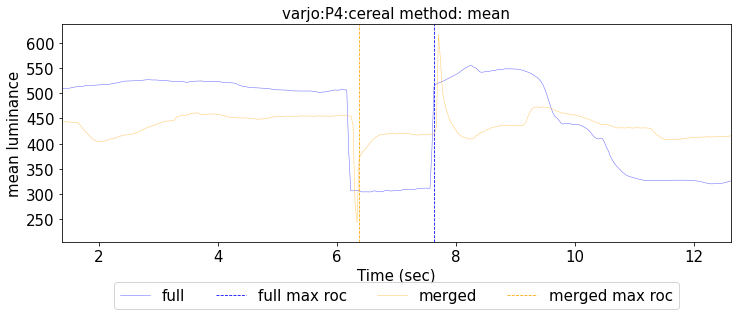

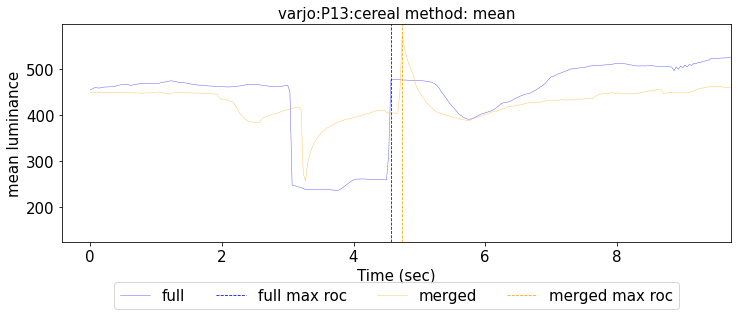

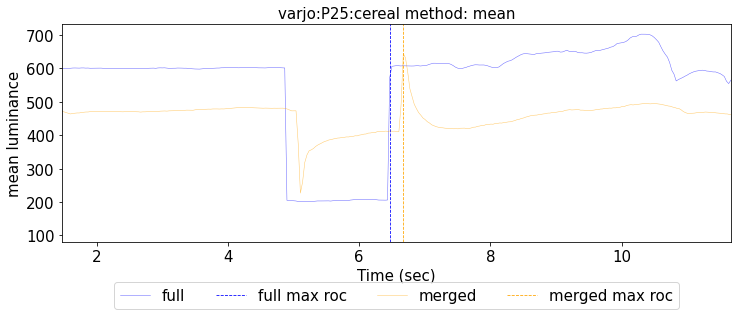

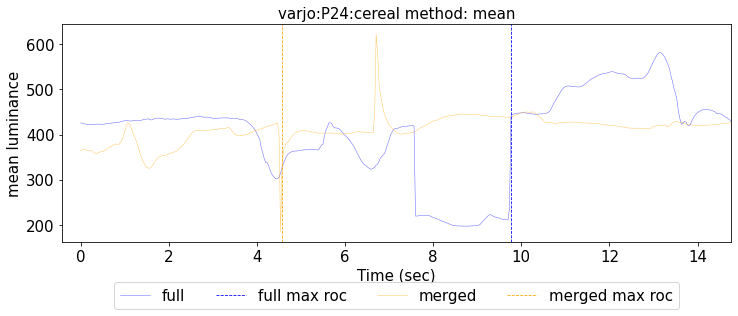

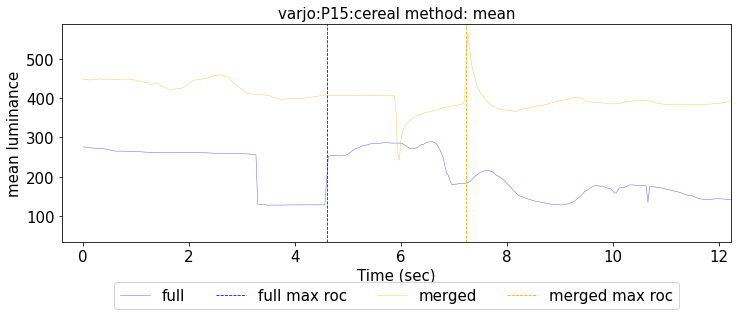

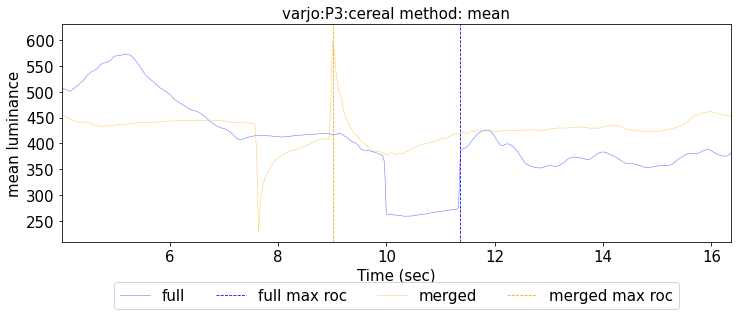

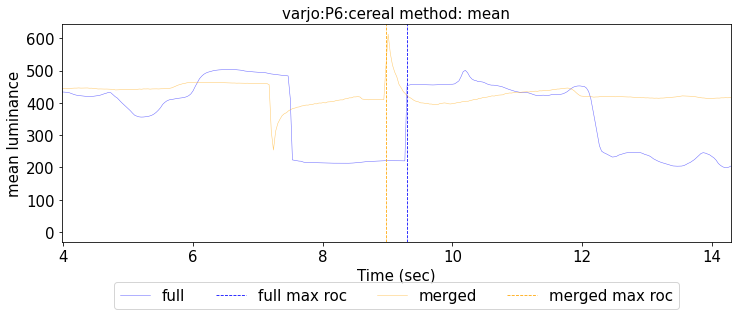

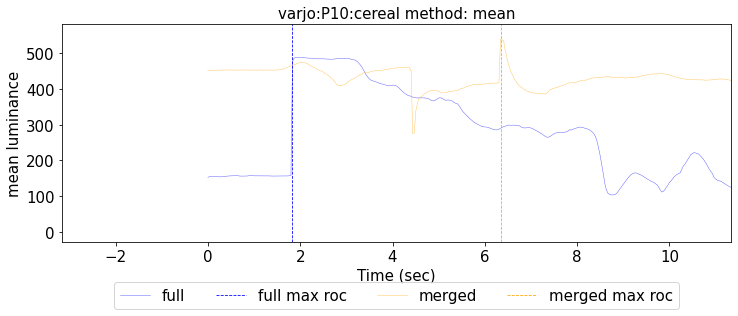

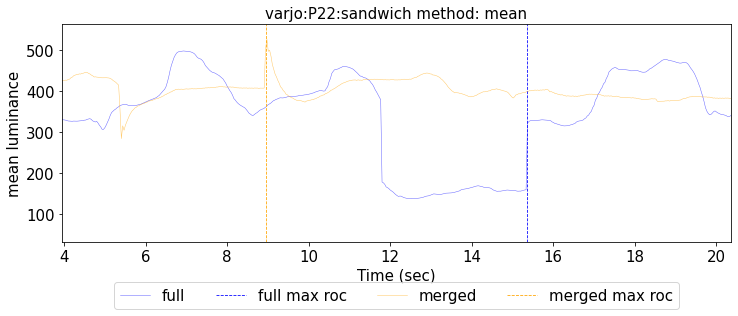

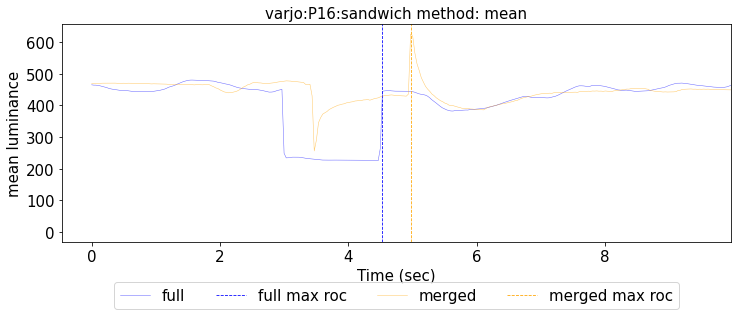

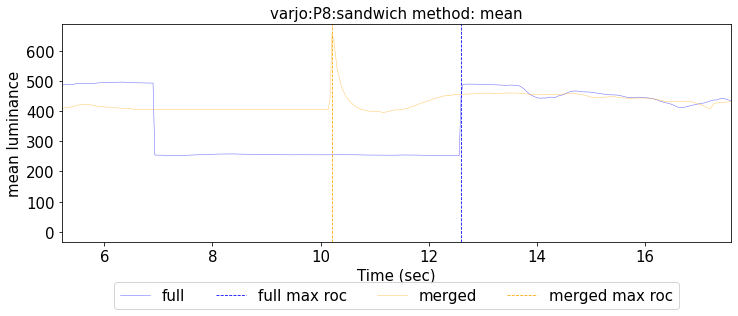

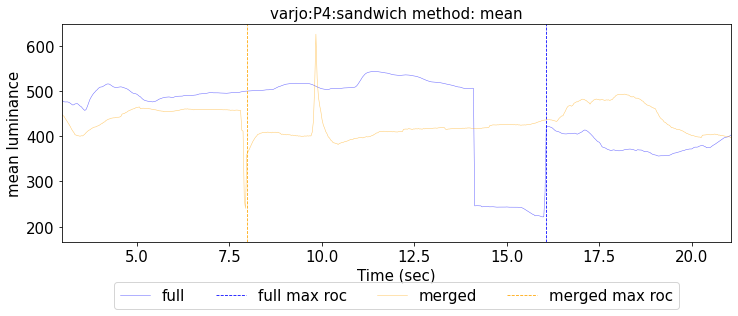

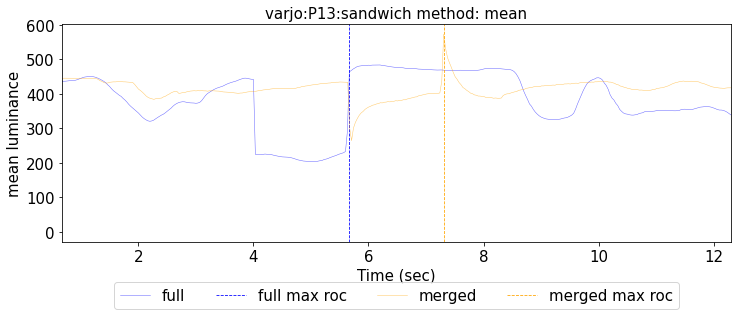

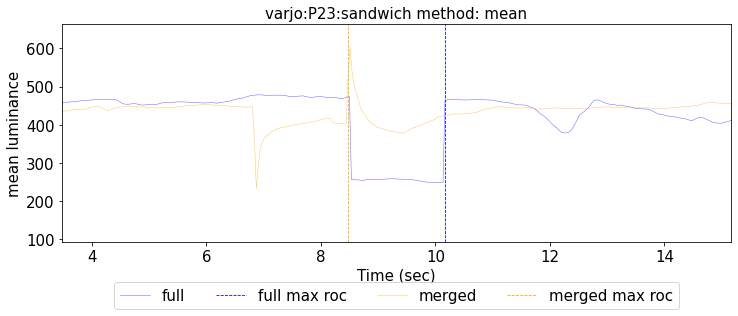

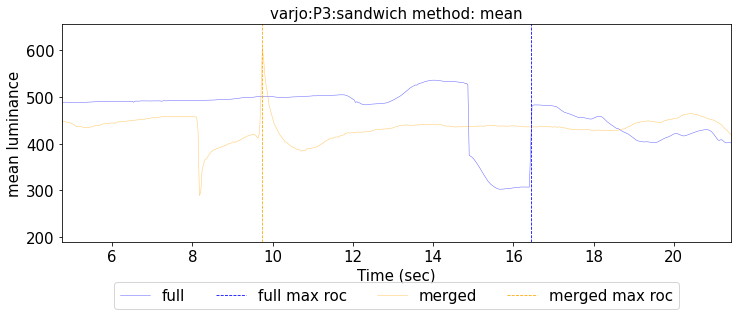

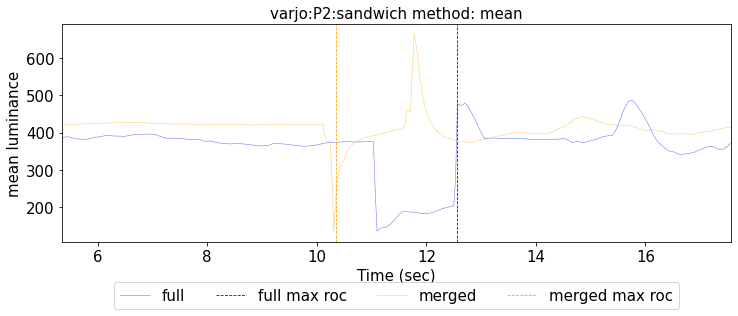

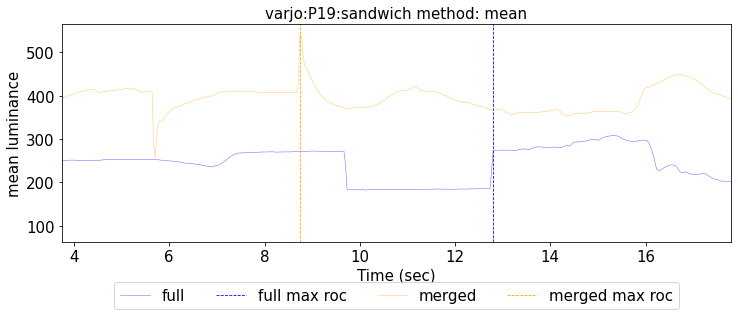

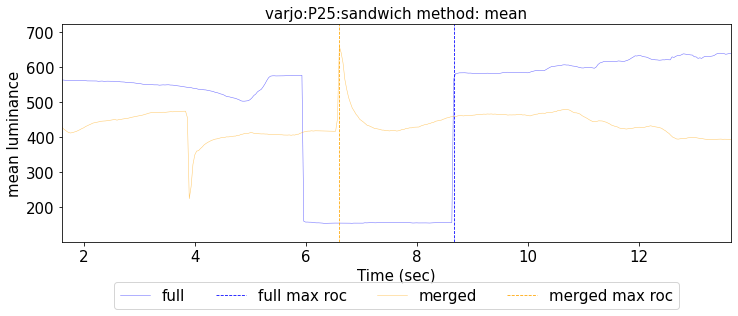

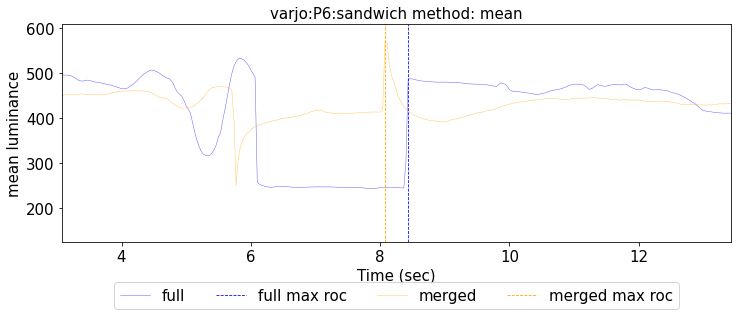

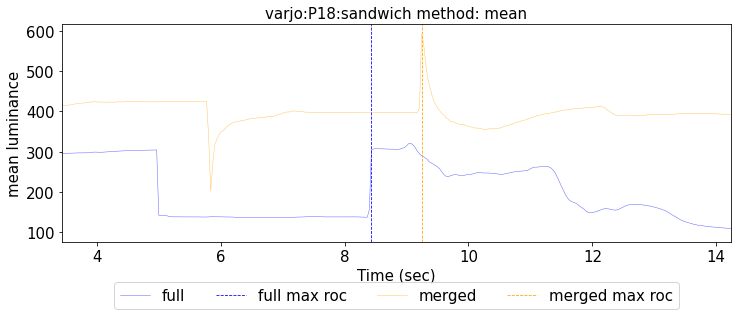

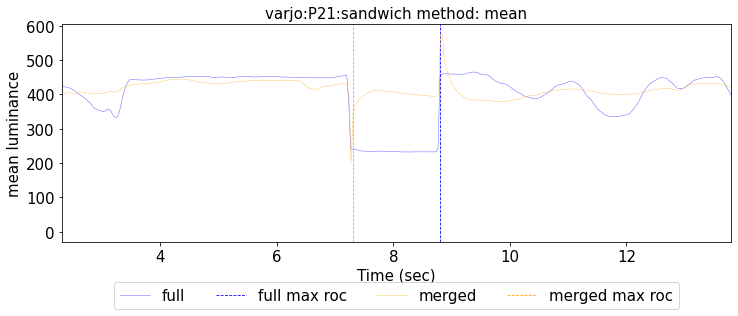

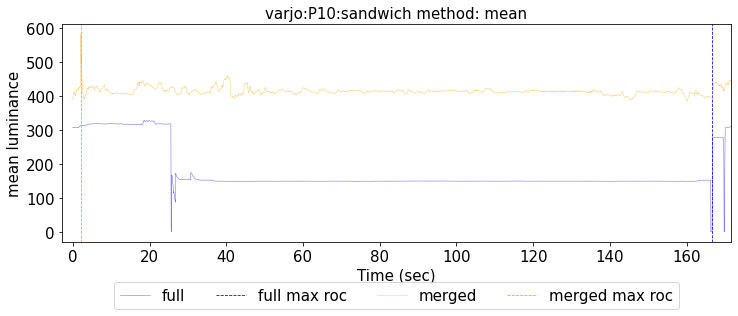

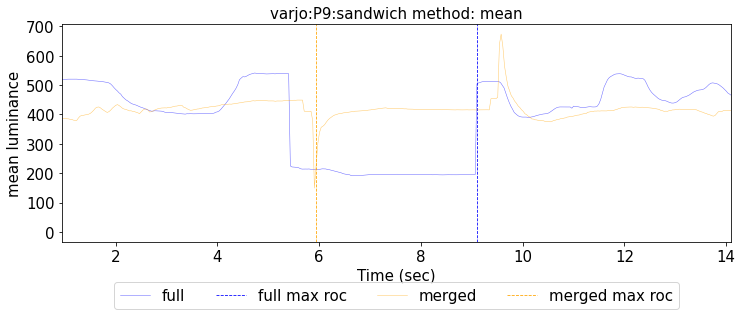

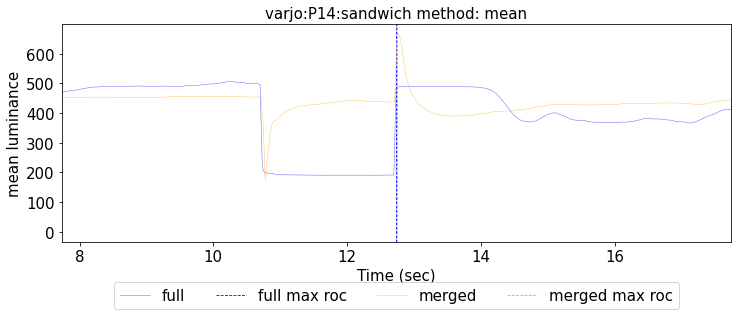

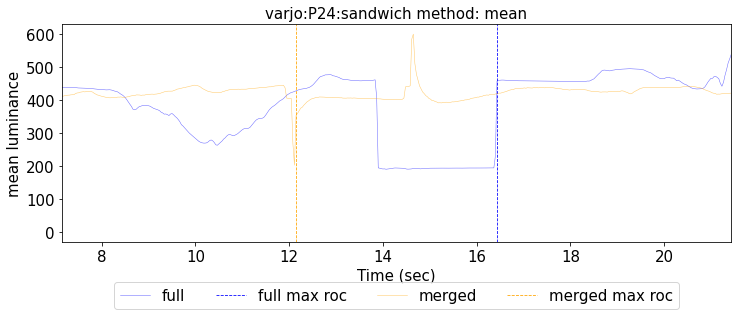

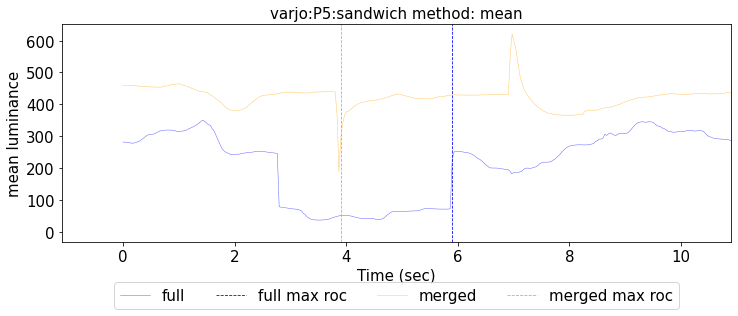

In [13]:
# plot results for max
out_paths = {'PI':'/data/AMPs/first-round/{method}_lum_roc/max_lum_roc/'.format(method=method),
             'varjo':'/data/AMPs/second-round/{method}_lum_roc/max_lum_roc/'.format(method=method)}
colors = {'full':'blue','merged':'orange'}

for HMD in min_max_lum.HMD.unique():
    for task in min_max_lum[min_max_lum.HMD==HMD].task.unique():
        _ = min_max_lum[min_max_lum.HMD==HMD][min_max_lum.task==task]
        for subID in _.subID.unique():
            temp = _[_.subID==subID]
            plt.figure(figsize=(12,4))
            xrange = []
            for idx, row in temp.iterrows():
                data = pd.read_csv(row.lum_path)
                x = data.frame.to_numpy()/fps[HMD][row.type]
                y = data[method]
                maxx = row['max_lum_time(s)']
                xrange.append(maxx)

                # make plot
                plt.plot(x,y,color=colors[row.type],alpha=0.6,linewidth=3,label=row.type)
                plt.axvline(maxx,linestyle='--',color=colors[row.type],linewidth=2,label=row.type+' max roc')
            
            # save plot
            plt.xlim((min(xrange)-5,max(xrange)+5))
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, ncol=4, fontsize=15)
            plt.title(HMD+':'+subID+':'+task+' method: '+method, fontsize=15)
            plt.xlabel('Time (sec)', fontsize=15)
            plt.ylabel(method+' luminance', fontsize=15)
            plt.savefig(out_paths[HMD]+subID+'_'+task+'_'+HMD)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.close()
            

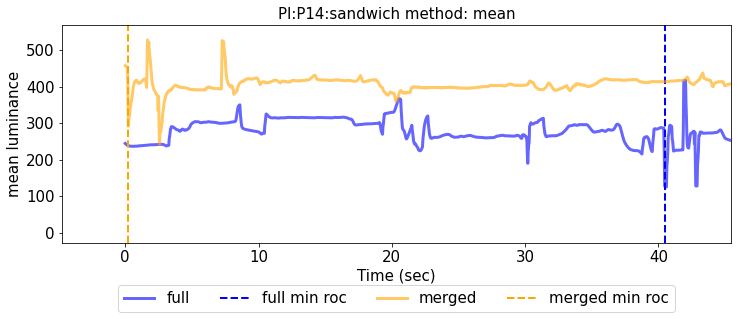

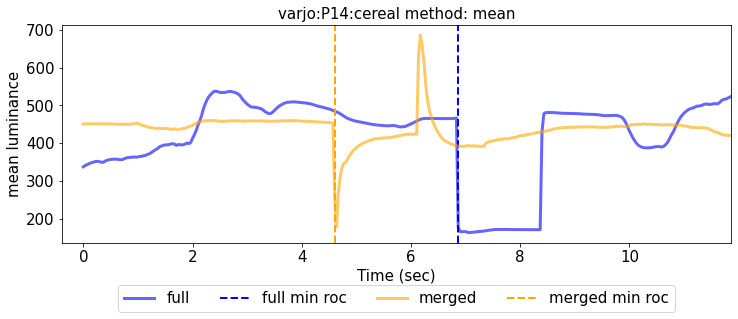

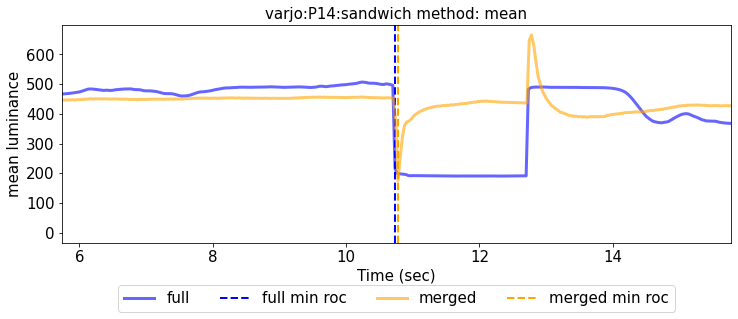

In [19]:
# plot results for min
out_paths = {'PI':'/data/AMPs/first-round/{method}_lum_roc/min_lum_roc/'.format(method=method),
             'varjo':'/data/AMPs/second-round/{method}_lum_roc/min_lum_roc/'.format(method=method)}
colors = {'full':'blue','merged':'orange'}

for HMD in min_max_lum.HMD.unique():
    for task in min_max_lum[min_max_lum.HMD==HMD].task.unique():
        _ = min_max_lum[min_max_lum.HMD==HMD][min_max_lum.task==task]
        for subID in _.subID.unique():
            
            temp = _[_.subID==subID]
            plt.figure(figsize=(12,4))
            xrange = []
            for idx, row in temp.iterrows():
                data = pd.read_csv(row.lum_path)
                x = data.frame.to_numpy()/fps[HMD][row.type]
                y = data[method]
                maxx = row['min_lum_time(s)']
                xrange.append(maxx)

                # make plot
                plt.plot(x,y,color=colors[row.type],alpha=0.6,linewidth=3,label=row.type)
                plt.axvline(maxx,linestyle='--',color=colors[row.type],linewidth=2,label=row.type+' min roc')
            
            # save plot
            plt.xlim((min(xrange)-5,max(xrange)+5))
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16), fancybox=True, ncol=4, fontsize=15)
            plt.title(HMD+':'+subID+':'+task+' method: '+method, fontsize=15)
            plt.xlabel('Time (sec)', fontsize=15)
            plt.ylabel(method+' luminance', fontsize=15)
            plt.savefig(out_paths[HMD]+subID+'_'+task+'_'+HMD)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.close()

In [9]:
# Output only varjo min (excluding P10, which failed)
test = pd.read_csv('/home/s202576/thesis_spring2022/NN/data_prep/mean_luminance.csv')
test.drop(['max_lum_roc','max_lum_frame','max_lum_time(s)'],axis=1,inplace=True)
test.drop(test[test.HMD=='PI'].index, axis=0, inplace=True)
test.drop(test[test.subID=='P10'].index, axis=0, inplace=True)
test.reset_index(inplace=True)
del test['index']
del test['Unnamed: 0']
test.head()

,HMD,task,subID,type,lum_path,dur(s),min_lum_roc,min_lum_frame,min_lum_time(s)
0,varjo,cereal,P14,full,/data/AMPs/second-round/avg-lum-per-frame/P14_...,172.733166,-0.621721,206.0,6.866660
1,varjo,cereal,P14,merged,/data/AMPs/second-round/avg-lum-per-frame/P14_...,173.173000,-0.434537,138.0,4.604600
2,varjo,cereal,P23,full,/data/AMPs/second-round/avg-lum-per-frame/P23_...,188.033152,-0.459796,201.0,6.699994
3,varjo,cereal,P23,merged,/data/AMPs/second-round/avg-lum-per-frame/P23_...,188.421566,-0.414869,177.0,5.905900
4,varjo,cereal,P19,full,/data/AMPs/second-round/avg-lum-per-frame/P19_...,137.433200,-0.376091,174.0,5.799994


In [10]:
print(len(test))

68


In [11]:
test.to_csv('/home/s202576/thesis_spring2022/NN/data_prep/min_mean_luminance_roc_varjo.csv')
test.to_csv('/data/Isabella/thesis_spring2022/offsets/min_mean_luminance_roc_varjo.csv')

In [12]:
df = pd.read_csv('/home/s202576/thesis_spring2022/NN/data_prep/min_mean_luminance_roc_varjo.csv')
for subID in df.subID.unique():
    for task in df[df.subID==subID].task.unique():
        print(subID, task)

P14 cereal
P14 sandwich
P23 cereal
P23 sandwich
P19 cereal
P19 sandwich
P2 cereal
P2 sandwich
P9 cereal
P9 sandwich
P18 cereal
P18 sandwich
P21 cereal
P21 sandwich
P22 cereal
P22 sandwich
P5 cereal
P5 sandwich
P16 cereal
P16 sandwich
P4 cereal
P4 sandwich
P13 cereal
P13 sandwich
P25 cereal
P25 sandwich
P24 cereal
P24 sandwich
P15 cereal
P3 cereal
P3 sandwich
P6 cereal
P6 sandwich
P8 sandwich
